In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

from torchvision import datasets, transforms
from torch.utils.data import random_split

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
# Loading the Fashion-MNIST dataset

# Define a transform to normalize the data
transform_train = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5))
                               ])
transform_test = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5))
                               ])
# Download and load the training data
trainset = datasets.FashionMNIST('MNIST_data/', download = True, train = True, transform = transform_train)
testset = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform_test)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size = 64, shuffle = True)

In [4]:
# Examine a sample
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


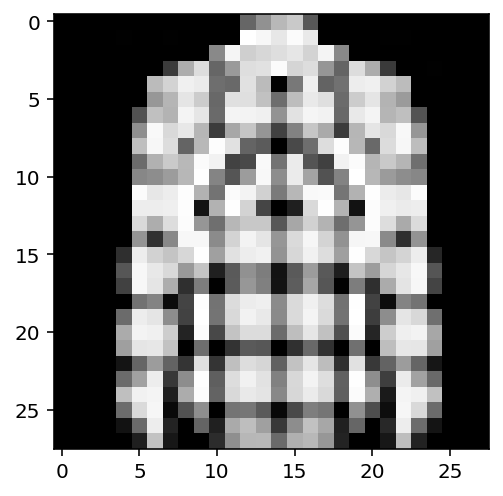

In [5]:
plt.imshow(images[1].numpy().squeeze(), cmap = 'Greys_r')

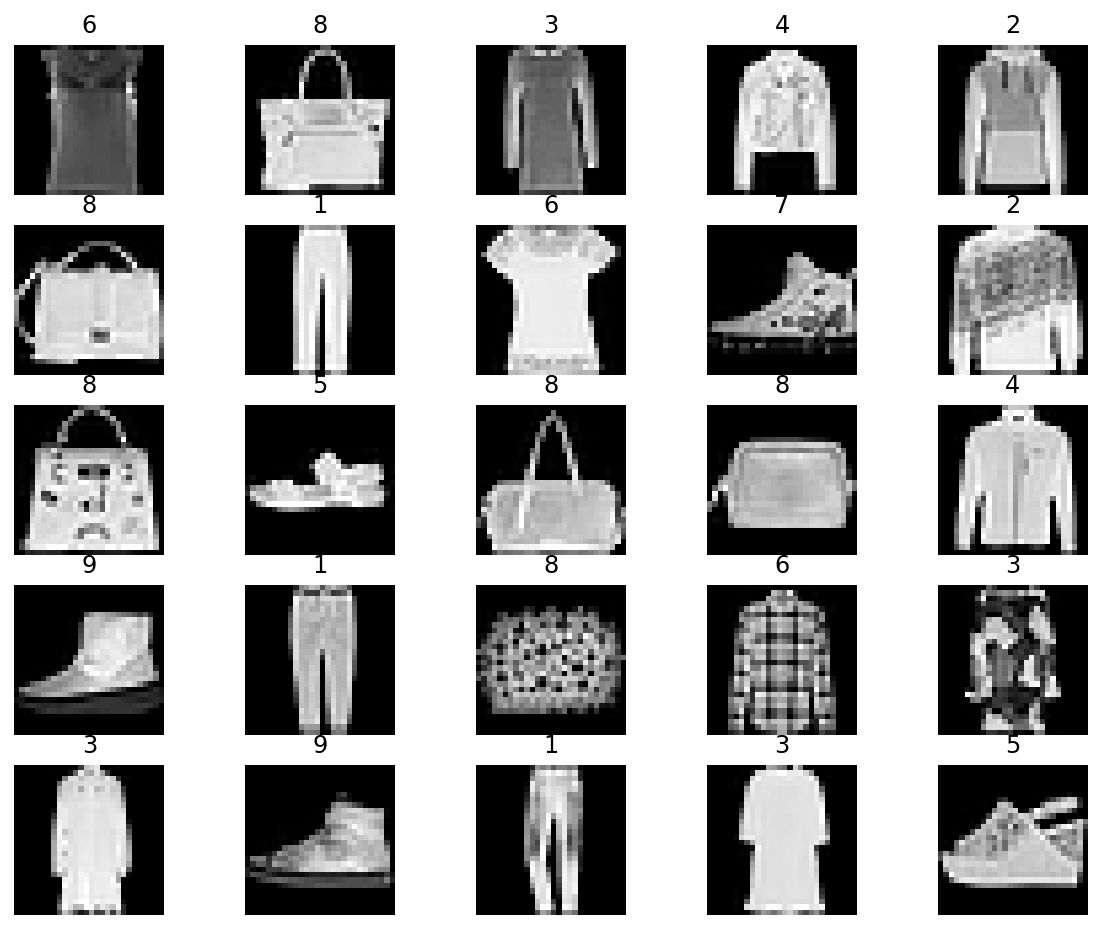

In [6]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(trainset), size=(1,)).item()
    img, label = trainset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [7]:
# Define the network architecture
from torch import nn, optim
import torch.nn.functional as F

model = nn.Sequential(nn.Linear(784, 512),
                      nn.ReLU(),
                      #nn.Dropout(0.1),
                      nn.Linear(512, 256),
                      nn.ReLU(),
                      #nn.Dropout(0.1),
                      nn.Linear(256, 500),
                      nn.ReLU(),
                      #nn.Dropout(0.1),
                      nn.Linear(500, 500),
                      nn.ReLU(),
                      #nn.Dropout(0.1),
                      nn.Linear(500, 10),
                      nn.LogSoftmax(dim = 1)
                     )

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [9]:
# Define the epochs
epochs = 30

train_losses, test_losses = [], []

for e in range(epochs):
  running_loss = 0
  for images, labels in trainloader:
    # Flatten Fashion-MNIST images into a 784 long vector
    images = images.view(images.shape[0], -1)
    
    # Training pass
    optimizer.zero_grad()
    
    output = model.forward(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
  else:
    test_loss = 0
    accuracy = 0
    
    # Turn off gradients for validation, saves memory and computation
    with torch.no_grad():
      # Set the model to evaluation mode
      model.eval()
      
      # Validation pass
      for images, labels in testloader:
        images = images.view(images.shape[0], -1)
        log_ps = model(images)
        test_loss += criterion(log_ps, labels)
        
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim = 1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
    
    model.train()
    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))
    
    print("Epoch: {}/{}..".format(e+1, epochs),
          "Training loss: {:.3f}..".format(running_loss/len(trainloader)),
          "Test loss: {:.3f}..".format(test_loss/len(testloader)),
          "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30.. Training loss: 1.605.. Test loss: 0.835.. Test Accuracy: 0.677
Epoch: 2/30.. Training loss: 0.686.. Test loss: 0.645.. Test Accuracy: 0.760
Epoch: 3/30.. Training loss: 0.554.. Test loss: 0.546.. Test Accuracy: 0.802
Epoch: 4/30.. Training loss: 0.491.. Test loss: 0.538.. Test Accuracy: 0.801
Epoch: 5/30.. Training loss: 0.451.. Test loss: 0.476.. Test Accuracy: 0.828
Epoch: 6/30.. Training loss: 0.422.. Test loss: 0.491.. Test Accuracy: 0.816
Epoch: 7/30.. Training loss: 0.400.. Test loss: 0.431.. Test Accuracy: 0.846
Epoch: 8/30.. Training loss: 0.381.. Test loss: 0.431.. Test Accuracy: 0.843
Epoch: 9/30.. Training loss: 0.366.. Test loss: 0.488.. Test Accuracy: 0.822
Epoch: 10/30.. Training loss: 0.354.. Test loss: 0.389.. Test Accuracy: 0.859
Epoch: 11/30.. Training loss: 0.342.. Test loss: 0.424.. Test Accuracy: 0.848


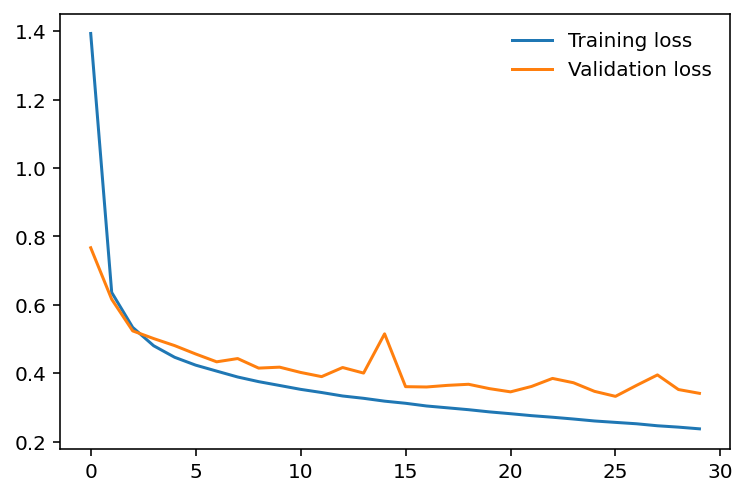

In [20]:
plt.plot(train_losses, label = "Training loss")
plt.plot(test_losses, label = "Validation loss")
plt.legend(frameon = False)